In [1]:
import pandas as pd
import geopandas as gp
import csv
import numpy as np
import xml.etree.ElementTree as ET
from xml.etree.ElementTree import Element
from copy import copy
import os
import inspect
from xml.dom import minidom
import math
from ortools.constraint_solver import routing_enums_pb2
from ortools.constraint_solver import pywrapcp
from time import time
import numpy as np
from argparse import ArgumentParser
from shapely.geometry import Point
import random


In [29]:
ship_type="B2B"

In [49]:
    tour_df=pd.read_csv("../../../FRISM_input_output/Sim_outputs/Tour_plan/%s_freight_tours.csv" %ship_type)
    carrier_df=pd.read_csv("../../../FRISM_input_output/Sim_outputs/Tour_plan/%s_carrier.csv" %ship_type)
    payload_df=pd.read_csv("../../../FRISM_input_output/Sim_outputs/Tour_plan/%s_payload.csv" %ship_type)

In [91]:
    dir_geo='../../../FRISM_input_output/Sim_inputs/Geo_data/'
    polygon_CBG = gp.read_file(dir_geo+'sfbay_freight.geojson') # include polygon for all the mesozones in the US

In [23]:
def random_points_in_polygon(polygon):
    temp = polygon.bounds
    finished= False
    while not finished:
        point = Point(random.uniform(temp.minx.values[0], temp.maxx.values[0]), random.uniform(temp.miny, temp.maxy.values[0]))
        finished = polygon.contains(point).values[0]
    return point

In [33]:
def random_loc (t_df,c_df,p_df,SFBay_CBG):
    c_df['depot_zone_x']=0.0
    c_df['depot_zone_y']=0.0
    c_df =c_df.sort_values(by=['carrierId']).reset_index(drop=True)
    carr_id=0.0
    
    for i in range(0,c_df.shape[0]):
        if c_df.carrierId[i] == carr_id:
            c_df.loc[i,'depot_zone_x']=c_df.loc[i-1,'depot_zone_x']
            c_df.loc[i,'depot_zone_y']=c_df.loc[i-1,'depot_zone_y']
        else:
            point=random_points_in_polygon(SFBay_CBG.geometry[SFBay_CBG.MESOZONE==c_df.depot_zone[i]])
            c_df.loc[i,'depot_zone_x']=point.x
            c_df.loc[i,'depot_zone_y']=point.y
            carr_id = c_df.carrierId[i]
    t_df=t_df.merge(c_df[['tourId','depot_zone_x','depot_zone_y']], right_on='tourId', left_on='tour_id', how='left')
    t_df=t_df.rename({'depot_zone_x':'departureLocation_x', 
                     'depot_zone_y':'departureLocation_y'}, axis=1)

    p_df['locationZone_x']=0.0
    p_df['locationZone_y']=0.0
    for i in range(0,p_df.shape[0]):
        if "d" in p_df.loc[i,"payloadId"]:
            p_df.loc[i,['locationZone_x','locationZone_y']]=c_df.loc[c_df["tourId"]==p_df.loc[i,"tourId"], ['depot_zone_x','depot_zone_y']]   
        else:
            point=random_points_in_polygon(SFBay_CBG.geometry[SFBay_CBG.MESOZONE==p_df['locationZone'][i]])
            p_df.loc[i,'locationZone_x']=point.x
            p_df.loc[i,'locationZone_y']=point.y

    return c_df, t_df, p_df

In [8]:
tour_df.head()

,tour_id,departureTimeInSec,departureLocation_zone,maxTourDurationInSec
0,0,43800,909,3600
1,1,43800,909,3600
2,2,28800,564,3600
3,3,41400,413,3600
4,4,31200,924,3600


In [9]:
carrier_df.head()

,carrierId,tourId,vehicleId,vehicleTypeId,depot_zone
0,685623,0,10,2,909
1,685623,1,11,2,909
2,685624,2,32,2,564
3,688382,3,39,2,413
4,688779,4,48,2,924


In [50]:
payload_df.head()

,payloadId,sequenceRank,tourId,payloadType,weightInlb,requestType,locationZone,estimatedTimeOfArrivalInSec,arrivalTimeWindowInSec_lower,arrivalTimeWindowInSec_upper,operationDurationInSec
0,cd0,1,0,1,226,1,872,44100,18000,79200,420
1,0,2,0,1,109,1,131,46020,18000,79200,540
2,8,3,0,1,730,1,5891,47520,18000,79200,2520
3,15,4,0,1,1395,1,5678,50400,18000,79200,4920
4,25,5,0,1,467,1,20091,105120,18000,1728000,960


In [13]:
"y" in "cd"

False

In [34]:
tour_df_xy,carrier_df_xy,payload_df_xy=random_loc (tour_df,carrier_df,payload_df, polygon_CBG)

KeyboardInterrupt: 

In [31]:
payload_df.dtypes

payloadId                       object
sequenceRank                     int64
tourId                           int64
payloadType                      int64
weightInlb                       int64
requestType                      int64
locationZone                     int64
estimatedTimeOfArrivalInSec      int64
arrivalTimeWindowInSec_lower     int64
arrivalTimeWindowInSec_upper     int64
operationDurationInSec           int64
dtype: object

In [51]:
c_df=carrier_df

In [52]:
p_df=payload_df

In [53]:
t_df=tour_df

In [94]:
SFBay_CBG=polygon_CBG

In [55]:
    c_df['depot_zone_x']=0.0
    c_df['depot_zone_y']=0.0
    c_df =c_df.sort_values(by=['carrierId']).reset_index(drop=True)
    carr_id=0.0
    
    for i in range(0,c_df.shape[0]):
        if c_df.carrierId[i] == carr_id:
            c_df.loc[i,'depot_zone_x']=c_df.loc[i-1,'depot_zone_x']
            c_df.loc[i,'depot_zone_y']=c_df.loc[i-1,'depot_zone_y']
        else:
            point=random_points_in_polygon(SFBay_CBG.geometry[SFBay_CBG.MESOZONE==c_df.depot_zone[i]])
            c_df.loc[i,'depot_zone_x']=point.x
            c_df.loc[i,'depot_zone_y']=point.y
            carr_id = c_df.carrierId[i]
    t_df=t_df.merge(c_df[['tourId','depot_zone_x','depot_zone_y']], right_on='tourId', left_on='tour_id', how='left')
    t_df=t_df.rename({'depot_zone_x':'departureLocation_x', 
                     'depot_zone_y':'departureLocation_y'}, axis=1)


In [122]:
    p_df['locationZone_x']=0.0
    p_df['locationZone_y']=0.0
    for i in range(0,p_df.shape[0]):
        print (i)
        if "d" in p_df.loc[i,"payloadId"]:
            t_index=c_df.index[c_df["tourId"]==p_df.loc[i,"tourId"]].values[0]
            p_df.loc[i,['locationZone_x','locationZone_y']]=c_df.loc[t_index, ['depot_zone_x','depot_zone_y']].values.tolist()  
        else:
            point=random_points_in_polygon(SFBay_CBG.geometry[SFBay_CBG.MESOZONE==p_df['locationZone'][i]])
            p_df.loc[i,'locationZone_x']=point.x
            p_df.loc[i,'locationZone_y']=point.y

0
1
2
3
4


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

5
6
7
8


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

9
10
11
12
13


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

14
15
16
17
18
19


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

20
21
22
23
24


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

25
26
27
28
29


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

30
31
32
33
34


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

35
36
37
38
39


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

40
41
42
43
44


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

45
46
47
48
49


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

50
51
52
53


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

54
55
56
57
58


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

59
60
61
62
63
64


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

65
66
67
68
69


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

70
71
72
73
74


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

75
76
77
78
79


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

80
81
82
83
84
85


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

86
87
88
89
90


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

91
92
93
94
95


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

96
97
98
99
100


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

101
102
103
104
105


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

106
107
108
109
110
111


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

112
113
114
115
116
117


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

118
119
120
121
122
123


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

124
125
126
127
128


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

129
130
131
132
133


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

134
135
136
137
138


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

139
140
141
142
143


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

144
145
146
147
148


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

149
150
151
152
153


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

154
155
156
157
158
159


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

160
161
162
163
164


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

165
166
167
168
169


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

170
171
172
173
174


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

175
176
177
178
179


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

180
181
182
183
184
185


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

186
187
188
189
190
191


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

192
193
194
195
196
197


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

198
199
200
201
202


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

203
204
205
206
207


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

208
209
210
211
212


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

213
214
215
216
217
218


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

219
220
221
222
223


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

224
225
226
227
228


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

229
230
231
232
233


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

234
235
236
237
238
239


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

240
241
242
243
244


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

245
246
247
248
249


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

250
251
252
253
254


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

255
256
257
258


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

259
260
261
262


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

263
264
265
266


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

267
268
269
270


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

271
272
273
274
275


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

276
277
278
279
280


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

281
282
283
284
285


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

286
287
288
289
290


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

291
292
293
294


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

295
296
297
298
299


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

300
301
302
303


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

304
305
306
307
308


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

309
310
311
312
313


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

314
315
316
317


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

318
319
320
321
322


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

323
324
325
326
327


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

328
329
330
331
332


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

333
334
335
336
337


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

338
339
340
341
342


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

343
344
345
346
347


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

348
349
350
351
352


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

353
354
355
356
357


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

358
359
360
361
362


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

363
364
365
366


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

367
368
369
370
371


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

372
373
374
375
376


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

377
378
379
380
381


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

382
383
384
385
386


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

387
388
389
390
391


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

392
393
394
395
396


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

397
398
399
400
401


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

402
403
404
405
406


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

407
408
409
410
411


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

412
413
414
415
416


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

417
418
419
420
421


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

422
423
424
425
426


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

427
428
429
430
431


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

432
433
434
435
436


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

437
438
439
440
441


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

442
443
444
445
446


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

447
448
449
450
451


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

452
453
454
455
456


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

457
458
459
460
461


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

462
463
464
465
466
467


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

468
469
470
471
472


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

473
474
475
476
477
478


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

479
480
481
482
483
484


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

485
486
487
488
489


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

490
491
492
493
494


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

495
496
497
498
499


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

500
501
502
503
504


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

505
506
507
508
509
510


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

511
512
513
514
515
516


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

517
518
519
520
521
522


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

523
524
525
526
527


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

528
529
530
531
532


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

533
534
535
536
537
538
539


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

540
541
542
543
544


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

545
546
547
548
549


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

550
551
552
553
554


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

555
556
557
558
559


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

560
561
562
563
564


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

565
566
567
568
569


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

570
571
572
573
574


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

575
576
577
578
579


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

580
581
582
583
584
585


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

586
587
588
589
590


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

591
592
593
594
595


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

596
597
598
599
600


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

601
602
603
604
605
606


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

607
608
609
610
611


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

612
613
614
615
616


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

617
618
619
620
621
622


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

623
624
625
626
627


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

628
629
630
631
632


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

633
634
635
636
637


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

638
639
640
641
642


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

643
644
645
646
647


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

648
649
650
651
652
653


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

654
655
656
657
658
659


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

660
661
662
663
664
665


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

666
667
668
669
670
671


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

672
673
674
675
676
677


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

678
679
680
681
682
683


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

684
685
686
687
688
689


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

690
691
692
693
694


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

695
696
697
698
699


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

700
701
702
703
704


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

705
706
707
708
709
710


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

711
712
713
714
715


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

716
717
718
719
720


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

721
722
723
724
725


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

726
727
728
729
730


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

731
732
733
734
735


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

736
737
738
739
740


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

741
742
743
744
745


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

746
747
748
749
750


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

751
752
753
754
755
756


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

757
758
759
760
761
762


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

763
764
765
766
767


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

768
769
770
771
772


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

773
774
775
776
777


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locatio

778
779
780


/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:
/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/3676463546.py:9: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  if SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]].values[0]==0:


KeyboardInterrupt: 

In [74]:
SFBay_CBG.geometry[SFBay_CBG.MESOZONE==p_df['locationZone'][i]]

6251    GEOMETRYCOLLECTION EMPTY
Name: geometry, dtype: geometry

In [109]:
SFBay_CBG.loc[g_index, "area"]==0

False

In [75]:
p_df['locationZone'][i]

6252

In [72]:
"d" in p_df.loc[i,"payloadId"]

False

In [62]:
t_index=c_df.index[c_df["tourId"]==p_df.loc[i,"tourId"]].values[0]

In [63]:
c_df.loc[t_index, ['depot_zone_x','depot_zone_y']].values.tolist()

[-121.9243393632834, 37.48729410792814]

In [64]:
p_df.loc[i,['locationZone_x','locationZone_y']]=c_df.loc[t_index, ['depot_zone_x','depot_zone_y']].values.tolist()

In [45]:
p_df.loc[i,['locationZone_x','locationZone_y']]

locationZone_x    NaN
locationZone_y    NaN
Name: 0, dtype: object

In [46]:
p_df.loc

In [65]:
p_df.head()

,payloadId,sequenceRank,tourId,payloadType,weightInlb,requestType,locationZone,estimatedTimeOfArrivalInSec,arrivalTimeWindowInSec_lower,arrivalTimeWindowInSec_upper,operationDurationInSec,locationZone_x,locationZone_y
0,cd0,1,0,1,226,1,872,44100,18000,79200,420,-121.924339,37.487294
1,0,2,0,1,109,1,131,46020,18000,79200,540,NaN,NaN
2,8,3,0,1,730,1,5891,47520,18000,79200,2520,NaN,NaN
3,15,4,0,1,1395,1,5678,50400,18000,79200,4920,NaN,NaN
4,25,5,0,1,467,1,20091,105120,18000,1728000,960,NaN,NaN


In [77]:
SFBay_CBG[SFBay_CBG.MESOZONE == 6252]

,GEOID,CBPZONE,MESOZONE,area,geometry
6251,060759901000,64075,6252,0.0,GEOMETRYCOLLECTION EMPTY


In [79]:
SFBay_CBG[SFBay_CBG.area == 0 ]

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/2242830175.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SFBay_CBG[SFBay_CBG.area == 0 ]


,GEOID,CBPZONE,MESOZONE,area,geometry
1046,060019900000,64001,1047,0.0,GEOMETRYCOLLECTION EMPTY
1958,060139900000,64013,1959,0.0,GEOMETRYCOLLECTION EMPTY
1978,060159900000,69015,1979,0.0,GEOMETRYCOLLECTION EMPTY
2823,060239901000,69023,2824,0.0,GEOMETRYCOLLECTION EMPTY
3800,060419901000,64041,3801,0.0,GEOMETRYCOLLECTION EMPTY
3896,060459901000,69045,3897,0.0,GEOMETRYCOLLECTION EMPTY
4302,060539900000,69053,4303,0.0,GEOMETRYCOLLECTION EMPTY
6251,060759901000,64075,6252,0.0,GEOMETRYCOLLECTION EMPTY
6809,060799900000,69079,6810,0.0,GEOMETRYCOLLECTION EMPTY
7272,060819901000,64081,7273,0.0,GEOMETRYCOLLECTION EMPTY


In [118]:
SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]]

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/1296316662.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]]


130    0.000017
dtype: float64

In [105]:
g_index

130

In [110]:
SFBay_CBG.geometry[SFBay_CBG.MESOZONE==p_df.depot_zone[1]]

AttributeError: 'DataFrame' object has no attribute 'depot_zone'

In [115]:
SFBay_CBG.geometry[SFBay_CBG.MESOZONE==p_df['locationZone'][1]]

130    MULTIPOLYGON (((-122.23499 37.80720, -122.2325...
Name: geometry, dtype: geometry

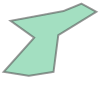

In [116]:
SFBay_CBG.geometry[130]

In [114]:
p_df['locationZone'][0]

872

In [123]:
SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]]

/var/folders/kr/2j58542j2_7chf9_h8bmr30mb0_4n0/T/ipykernel_15666/1296316662.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  SFBay_CBG.area[SFBay_CBG.MESOZONE==p_df['locationZone'][i]]


8623    0.000205
dtype: float64

In [126]:
random_points_in_polygon(SFBay_CBG.geometry[SFBay_CBG.MESOZONE==6252])

KeyboardInterrupt: 

In [137]:
if SFBay_CBG.geometry[SFBay_CBG.MESOZONE==1].is_empty:
    print ("yes")

ValueError: The truth value of a Series is ambiguous. Use a.empty, a.bool(), a.item(), a.any() or a.all().

In [139]:
SFB=SFBay_CBG.geometry.is_empty

2    False
dtype: bool